In [1]:
# https://platform.olimpiada-ai.ro/problems/35

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train = pd.read_csv("/kaggle/input/real-vs-ai-art/train.csv")
test = pd.read_csv("/kaggle/input/real-vs-ai-art/test.csv")

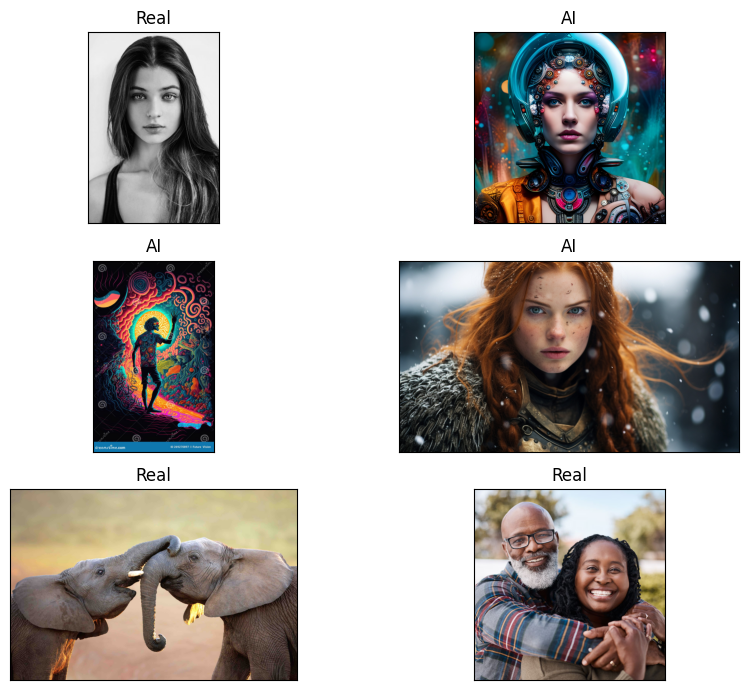

In [4]:
plt.figure(figsize=(10, 7))

n_rows = 3
for i in range(n_rows):
    plt.subplot(n_rows, 2, i*2+1)
    plt.title('AI' if train['Label'][i*2]==1 else 'Real')
    plt.imshow(Image.open(os.path.join('/kaggle/input/real-vs-ai-art', train['ImagePath'][i*2])))
    plt.xticks([])
    plt.yticks([])
    plt.subplot(n_rows, 2, i*2+2)
    plt.title('AI' if train['Label'][i*2+1]==1 else 'Real')
    plt.imshow(Image.open(os.path.join('/kaggle/input/real-vs-ai-art', train['ImagePath'][i*2+1])))
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()

In [5]:
from transformers import AutoImageProcessor, AutoModel

model_checkpoint = "facebook/dinov2-large"

processor = AutoImageProcessor.from_pretrained(model_checkpoint)
model = AutoModel.from_pretrained(model_checkpoint).to(device)

2025-11-30 03:05:17.272710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764471917.438581      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764471917.488023      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/549 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [6]:
image = Image.open(os.path.join('/kaggle/input/real-vs-ai-art', train['ImagePath'][0]))
inputs = processor(images=image, return_tensors="pt")
inputs.to(model.device)
with torch.no_grad():
    outputs = model(**inputs)
embeddings = F.normalize(outputs.last_hidden_state[:, 0, :].detach().cpu()).numpy()
embeddings.shape

(1, 1024)

In [7]:
train_embeddings = []

batch_size = 8

for i in tqdm(range(0, len(train), batch_size)):
    image_paths = train['ImagePath'][i:i+batch_size].tolist()
    images = [Image.open(os.path.join('/kaggle/input/real-vs-ai-art', p)).convert('RGB') for p in image_paths]
    inputs = processor(images=images, return_tensors='pt')
    inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    emb = F.normalize(outputs.last_hidden_state[:, 0, :].detach().cpu(), p=2, dim=1).numpy()
    
    train_embeddings.append(emb)

train_embeddings = np.concatenate(train_embeddings, axis=0)

  0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
test_embeddings = []

batch_size = 8

for i in tqdm(range(0, len(test), batch_size)):
    image_paths = test['ImagePath'][i:i+batch_size].tolist()
    images = [Image.open(os.path.join('/kaggle/input/real-vs-ai-art', p)).convert('RGB') for p in image_paths]
    inputs = processor(images=images, return_tensors='pt')
    inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    emb = F.normalize(outputs.last_hidden_state[:, 0, :].detach().cpu(), p=2, dim=1).numpy()
    test_embeddings.append(emb)

test_embeddings = np.concatenate(test_embeddings, axis=0)

  0%|          | 0/25 [00:00<?, ?it/s]

In [9]:
del processor
del model
torch.cuda.empty_cache()

In [10]:
from sklearn.model_selection import train_test_split
from catboost import Pool

X_train, X_valid, y_train, y_valid = train_test_split(train_embeddings, train['Label'].to_numpy(), random_state=42, test_size=0.2)
X_test = test_embeddings

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

In [35]:
from catboost import CatBoostClassifier

params = {
    'iterations': 140,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'metric_period': 20,
    'max_depth': 6,
    'task_type': 'GPU',
    'random_state': 42
}

model = CatBoostClassifier(**params)

model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.167392
0:	learn: 0.7805596	test: 0.6589595	best: 0.6589595 (0)	total: 14ms	remaining: 1.95s
20:	learn: 0.9985141	test: 0.7784431	best: 0.7784431 (20)	total: 220ms	remaining: 1.24s
40:	learn: 1.0000000	test: 0.7857143	best: 0.7857143 (40)	total: 420ms	remaining: 1.01s
60:	learn: 1.0000000	test: 0.8121212	best: 0.8121212 (60)	total: 613ms	remaining: 794ms
80:	learn: 1.0000000	test: 0.8250000	best: 0.8250000 (80)	total: 802ms	remaining: 584ms
100:	learn: 1.0000000	test: 0.8292683	best: 0.8292683 (100)	total: 992ms	remaining: 383ms
120:	learn: 1.0000000	test: 0.8333333	best: 0.8333333 (120)	total: 1.18s	remaining: 186ms
139:	learn: 1.0000000	test: 0.8313253	best: 0.8333333 (120)	total: 1.36s	remaining: 0us
bestTest = 0.8333333333
bestIteration = 120
Shrink model to first 121 iterations.


In [36]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_valid)

score = f1_score(y_valid, y_pred)

print(f"Score: {score:.5f}")

Score: 0.83333


In [37]:
y_pred = model.predict(X_test)

subm = pd.DataFrame({
    'SampleID': test['SampleID'],
    'Label': y_pred
})

subm.head()

,SampleID,Label
0,775,1
1,776,1
2,777,0
3,778,0
4,779,1


In [38]:
subm.to_csv("submission.csv", index=False)